# 10. Sparsity (Compactness)
Users prefer clear, concise explanations highlighting only key regions rather than widespread areas.

In [ ]:
from scipy.stats import spearmanr
from skimage.segmentation import slic
import sklearn
import seaborn as sns
from matplotlib import colors as mcolors
import matplotlib.patches as mpatches

def predict_prob(images):
  return loaded_model.predict(images)

# Crop and preprocess image
def crop_image(image_path, crop_size=240):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    start = (299 - crop_size) // 2
    return image[start:start+crop_size, start:start+crop_size]

# Normalize heatmap
def normalize_heatmap(heatmap, epsilon=1e-8):
    heatmap = np.nan_to_num(heatmap)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + epsilon)
    return np.clip(heatmap,0,1)

# Score-CAM
def score_cam_agreement(model, img_array, layer_name, class_index=None, top_k = 100):
    target_layer = model.get_layer(layer_name)
    cam_model = tf.keras.Model(inputs=model.input, outputs=[target_layer.output, model.output])

    activation_maps, predictions = cam_model(img_array)
    activation_maps = activation_maps[0].numpy()

    if class_index is None:
        class_index = np.argmax(predictions[0])

    # Compute variance and select top-k activation maps
    variances = np.var(activation_maps, axis=(0,1))
    top_indices = np.argsort(variances)[-top_k:]

    activation_maps_subset = activation_maps[:,:,top_indices]
    n_maps = activation_maps_subset.shape[-1]
    input_shape = img_array.shape[1:3]

    score_weights = []

    #print("n_maps: ",n_maps)

    for i in range(n_maps):
      act_map = activation_maps_subset[:,:,i]
      act_map_revised = cv2.resize(act_map, input_shape, interpolation=cv2.INTER_LINEAR)
      act_map_normalized = normalize_heatmap(act_map_revised)

      # Mask the input image
      masked_input = img_array.copy()
      masked_input[0] *= np.expand_dims(act_map_normalized,axis=-1)

      # Forward pass
      pred_masked = model.predict(masked_input,verbose=0)
      score_weights.append(pred_masked[0][class_index])

    score_weights = np.maximum(score_weights, 0)

    # Compute final CAM
    score_cam_map = np.zeros(activation_maps_subset.shape[:2], dtype = np.float32)
    for i, weight in enumerate(score_weights):
      score_cam_map += weight * activation_maps_subset[:,:,i]

    score_cam_map = np.maximum(score_cam_map, 0)
    score_cam_map /= (np.max(score_cam_map) + 1e-8)

    return score_cam_map

# Compute Grad-CAM
def compute_gradcam(model, image, layer_name, class_index):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    weights = tf.reduce_mean(grads, axis=(1, 2))
    gradcam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1).numpy()[0]
    gradcam = np.maximum(gradcam, 0)
    return gradcam

def modify_model_guided_backprop(model):
  @tf.custom_gradient
  def guided_relu(x):
    def grad(dy):
      return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy
    return tf.nn.relu(x), grad

  def replace_relu(layer):
    if hasattr(layer,'activation') and layer.activation == tf.keras.activations.relu:
      config = layer.get_config()
      config['activation'] = guided_relu
      return layer.__class__.from_config(config)
    return layer

  gb_model = tf.keras.models.clone_model(
      model,
      clone_function=replace_relu
  )

  gb_model.set_weights(model.get_weights())
  return gb_model

# Guided Backpropagation
def guided_backprop(model, image, class_index):
    gb_model = modify_model_guided_backprop(model)

    image = tf.cast(image, tf.float32)
    image = tf.Variable(image)

    with tf.GradientTape() as tape:
        tape.watch(image)
        predictions = gb_model(image)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, image)[0].numpy()
    return normalize_heatmap(grads)

# Combine Grad-CAM and Guided Backprop
def guided_gradcam(gradcam_heatmap, guided_backprop_output):
    heatmap_resized = cv2.resize(gradcam_heatmap, (guided_backprop_output.shape[1],guided_backprop_output.shape[0]),interpolation=cv2.INTER_LINEAR)
    heatmap_resized = heatmap_resized[..., np.newaxis]

    gradcam = np.clip(heatmap_resized,0,1)

    guided_gradcam_output = guided_backprop_output * heatmap_resized
    return normalize_heatmap(guided_gradcam_output)

# Binarize by keeping only top N% of pixels
def binarize_heatmap(heatmap, top_percent):
  threshold = np.percentile(heatmap,100 * (1-top_percent))
  return (heatmap >= threshold).astype(np.uint8)

def overlay_mask_on_image(image, mask, color=(255, 0, 0), alpha=0.5):
    mask_rgb = np.zeros_like(image)
    mask_rgb[mask == 1] = color
    overlay = cv2.addWeighted(image, 1 - alpha, mask_rgb, alpha, 0)
    return overlay

def show_cam_on_image(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation= cv2.INTER_LINEAR)
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), colormap)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    img_uint8 = np.uint8(255 * img)

    overlay = cv2.addWeighted(img_uint8, 1 - alpha, heatmap_colored, alpha, 0)
    return overlay

explainer = lime.lime_image.LimeImageExplainer(kernel_width=0.25, random_state=42)

class_names = ["MILCO", "NOMBO"]

def generate_distinct_colors(n):
    custom_palette = [
        "#e6194b",  # red
        "#3cb44b",  # green
        "#ff69b4",  # pink
        "#4363d8",  # blue
        "#800000",   # maroon (replacing orange)
        "#008080",  # teal
        "#9a6324"  # brown
    ]
    return [mcolors.to_rgb(c) for c in custom_palette[:n]]

def lime_explain(image_path):
    rgb_img = crop_image(image_path)

    image_arr = img_to_array(rgb_img).astype(np.float32)
    image_arr = preprocess_input(image_arr)
    input_tensor = np.expand_dims(image_arr, axis=0)

    rgb_img_np = np.array(rgb_img).astype(np.float32) / 255.0

    prediction = loaded_model.predict(input_tensor)
    predicted_class = np.argmax(prediction)

    rgb_img_np = rgb_img.astype(np.float32) / 255.0
    custom_background = cv2.GaussianBlur(rgb_img_np, (25, 25), sigmaX=10)

    segments = slic(rgb_img, n_segments=200, compactness=20)

    num_samples = 700
    data, labels = explainer.data_labels(
        image=rgb_img_np,
        fudged_image=custom_background,
        segments=segments,
        classifier_fn=predict_prob,
        num_samples=num_samples
    )

    distances = sklearn.metrics.pairwise_distances(
        data,
        data[0].reshape(1, -1),
        metric='cosine'
    ).ravel()

    ret_exp = lime.lime_image.ImageExplanation(rgb_img_np, segments)

    intercept, local_exp, score, local_pred = explainer.base.explain_instance_with_data(
        data, labels, distances, predicted_class, num_features=len(segments)
    )

    ret_exp.intercept = {predicted_class: intercept}
    ret_exp.local_exp = {predicted_class: local_exp}
    ret_exp.score = score
    ret_exp.local_pred = {predicted_class: local_pred}

    img, mask = ret_exp.get_image_and_mask(
        label=predicted_class,
        positive_only=True,
        num_features=1000,
        hide_rest=False
    )

    threshold = 0.05

    # Keep only positively contributing segments
    positive_segments_weights = [seg for seg in ret_exp.local_exp[predicted_class] if seg[1] > 0]
    sorted_segments = sorted(positive_segments_weights, key=lambda x: -x[1])
    top_k = max(1, int(len(sorted_segments) * threshold))
    top_segments = sorted_segments[:top_k]

    top_segment_ids = [seg_id for seg_id, _ in top_segments]
    top_segment_weights = [weight for _,weight in top_segments]

    # Binary mask with 1s where segments are positively contributing
    lime_binary_mask = np.isin(segments, top_segment_ids).astype(np.uint8)

    colored_mask = np.zeros((*segments.shape, 3), dtype=np.float32)
    segment_colors = generate_distinct_colors(len(top_segment_ids))

    for idx, seg_id in enumerate(top_segment_ids):
        colored_mask[segments == seg_id] = segment_colors[idx]

    alpha = 0.6
    blended_image = 1.0 * rgb_img_np + alpha * colored_mask

    legend_patches = [mpatches.Patch(color=segment_colors[idx],
                                     label=f'S. {seg_id}: {top_segment_weights[idx]:.4f}')
                      for idx, seg_id in enumerate(top_segment_ids)]

    #fig, ax = plt.subplots(1, 3, figsize=(22, 7))

    #ax[0].imshow(mark_boundaries(rgb_img_np, segments, color=(0, 1, 1)))
    #ax[0].set_title("Segmented Image")
    #ax[0].axis("off")

    #ax[1].imshow(mark_boundaries(rgb_img_np, mask, color=(0, 1, 1)))
    #ax[1].set_title(f"Explanation class: {class_names[predicted_class]}")
    #ax[1].axis("off")

    #ax[2].imshow(blended_image)
    #ax[2].set_title("Top 5% Positive Segments")
    #ax[2].axis("off")
    #ax[2].legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    #plt.tight_layout()
    #plt.show()

    #print("Predicted class: ",predicted_class)
    #print("Image: ",image_path)
    #print("Intercept: ", intercept)
    #print("Score: ", score)
    #print("Local pred: ", local_pred)
    #print(f"Explanation (class {class_names[predicted_class]}):")
    #print(top_segments)

    return lime_binary_mask, mask

def gini_coefficient(heatmap):
    """
    higher Gini = more sparse (concentrated)
    """
    flat = heatmap.flatten()
    flat = np.sort(flat)
    n = len(flat)
    index = np.arange(1, n+1)
    return (np.sum((2 * index - n - 1) * flat)) / (n * np.sum(flat))

In [ ]:
loaded_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_820 (Conv2D) │ (None, 119, 119,  │        864 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 119, 119,  │         96 │ conv2d_820[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_812      │ (None, 119, 119,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_821 (Conv2D) │ (None, 117, 117,  │      9,216 │ activation_812[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 117, 117,  │         96 │ conv2d_821[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_813      │ (None, 117, 117,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_822 (Conv2D) │ (None, 117, 117,  │     18,432 │ activation_813[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 117, 117,  │        192 │ conv2d_822[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_814      │ (None, 117, 117,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 58, 58,    │          0 │ activation_814[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_823 (Conv2D) │ (None, 58, 58,    │      5,120 │ max_pooling2d_24… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 58, 58,    │        240 │ conv2d_823[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_815      │ (None, 58, 58,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_824 (Conv2D) │ (None, 56, 56,    │    138,240 │ activation_815[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        576 │ conv2d_824[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_816      │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 57,412,776 (219.01 MB)

 Trainable params: 1,025,218 (3.91 MB)

 Non-trainable params: 54,337,120 (207.28 MB)

 Optimizer params: 2,050,438 (7.82 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
Prediction: [[9.9986732e-01 1.3268138e-04]]
Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


  0%|          | 0/700 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 

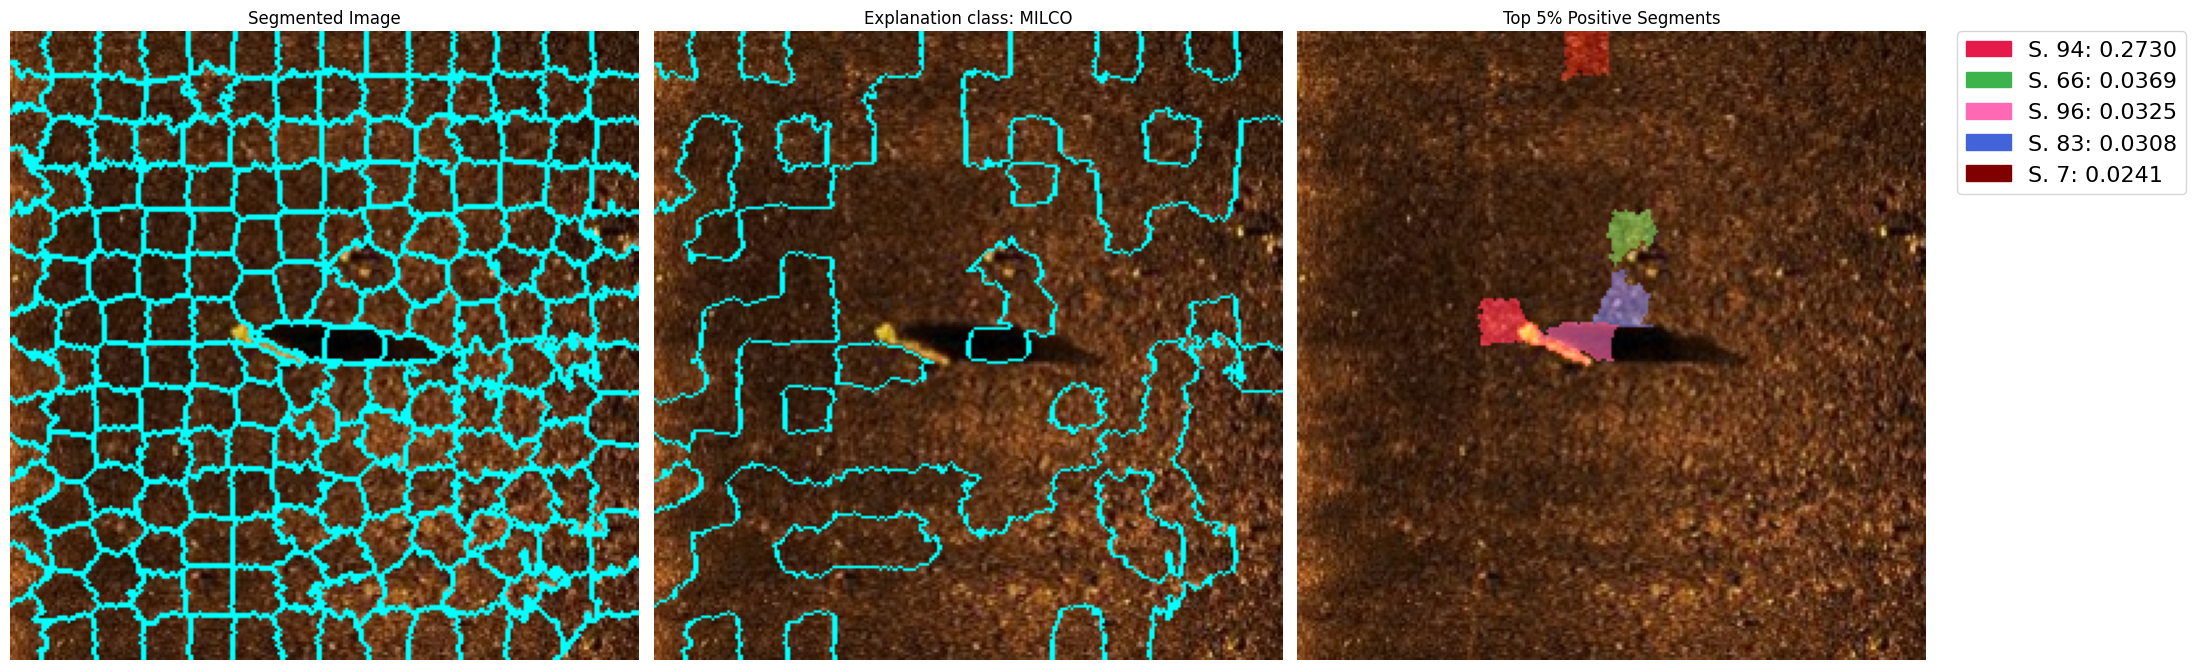

Predicted class:  0
Image:  /content/data/output/0089_2015_0_0.jpg
Intercept:  0.6769152114526499
Score:  0.7700966765797863
Local pred:  [1.00359294]
Explanation (class MILCO):
[(np.int64(94), np.float64(0.2729603915332117)), (np.int64(66), np.float64(0.036907616499382956)), (np.int64(96), np.float64(0.03247140299936775)), (np.int64(83), np.float64(0.0307723188094738)), (np.int64(7), np.float64(0.024135356190181274))]
Gini coefficient (higher gini = more sparse)
LIME Gini:  0.9738715277777777
n_maps:  50
(6, 6)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 240, 240, 3))
  warnings.warn(msg)


(6, 6)
(240, 240)
(240, 240)
Sparsity percent: % of pixels needed to reach the threshold
Grad-CAM sparsity:  0.001736111111111111
Score-CAM sparsity:  0.001736111111111111
Gini coefficient (higher gini = more sparse)
Grad-CAM Gini:  0.6233198996894743
Score-CAM Gini:  0.6506403749342806
Entropy (higher entropy = more sparse)
Grad-CAM entropy:  10.271208
Score-CAM entropy:  10.201258


(np.float64(-0.5), np.float64(239.5), np.float64(239.5), np.float64(-0.5))

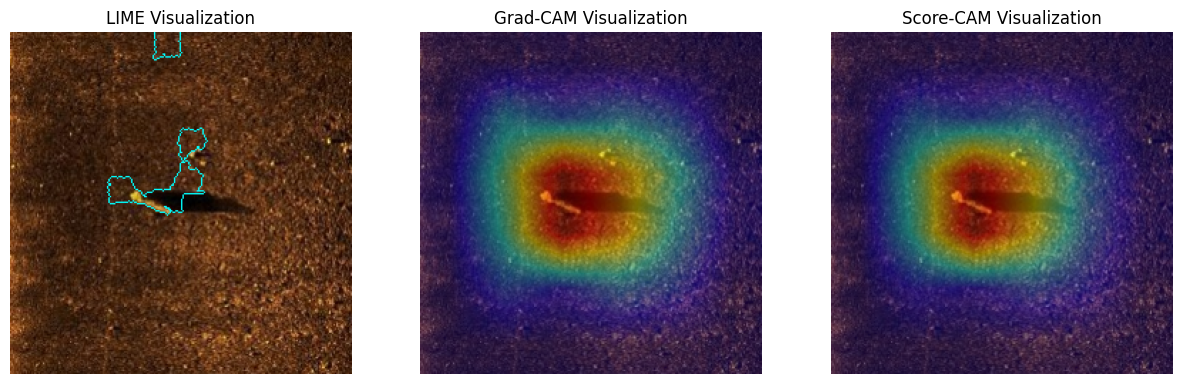

In [ ]:
# Define image path
#image_path = '/content/data/output/0023_2015_0_0.jpg'
#image_path = '/content/data/output/0007_2015_0_0.jpg'
#image_path = "/content/data/output/0037_2015_0_0.jpg"
#image_path = "/content/data/output/0074_2015_3_1.jpg"
#image_path = "/content/data/output/0021_2015_0_0.jpg"
image_path = "/content/data/output/0089_2015_0_0.jpg"

rgb_img = crop_image(image_path)
input_tensor = preprocess_input(np.expand_dims(rgb_img.astype(np.float32), axis=0))

prediction = loaded_model.predict(input_tensor)
print("Prediction:",prediction)
predicted_class = np.argmax(prediction)
print("Predicted class:", predicted_class)

# Layer
#conv_layer_name = 'conv2d_1024' # model A
conv_layer_name = 'conv_7b' # model B

# Generate binary mask LIME
binarized_lime, mask_lime = lime_explain(image_path)


gini_lime = gini_coefficient(binarized_lime)
print("Gini coefficient (higher gini = more sparse)")
print("LIME Gini: ",gini_lime)

# Generate Score-CAM heatmap
score_cam_heatmap = score_cam_agreement(loaded_model, input_tensor, conv_layer_name, predicted_class)

print(score_cam_heatmap.shape)

# Compute Grad-CAM
grad_cam_heatmap = compute_gradcam(loaded_model, input_tensor, conv_layer_name, predicted_class)

print(grad_cam_heatmap.shape)

input_h, input_w = rgb_img.shape[:2]
gradcam_norm = normalize_heatmap(cv2.resize(grad_cam_heatmap, (input_w, input_h), interpolation=cv2.INTER_LINEAR))
scorecam_norm = normalize_heatmap(cv2.resize(score_cam_heatmap, (input_w, input_h), interpolation=cv2.INTER_LINEAR))

print(gradcam_norm.shape)
print(scorecam_norm.shape)

gini_gradcam = gini_coefficient(gradcam_norm)
gini_score_cam = gini_coefficient(scorecam_norm)

print("Gini coefficient (higher gini = more sparse)")
print("Grad-CAM Gini: ",gini_gradcam)
print("Score-CAM Gini: ",gini_score_cam)

overlay_gradcam = show_cam_on_image(rgb_img.astype(np.float32) / 255.0, gradcam_norm)
overlay_scorecam = show_cam_on_image(rgb_img / 255.0, scorecam_norm)

# Plot images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(mark_boundaries(rgb_img, binarized_lime, color=(0, 1, 1)))
axes[0].set_title("LIME Visualization")
axes[0].axis('off')

axes[1].imshow(overlay_gradcam)
axes[1].set_title("Grad-CAM Visualization")
axes[1].axis('off')

axes[2].imshow(overlay_scorecam)
axes[2].set_title("Score-CAM Visualization")
axes[2].axis('off')

In [ ]:
# List of 20 image paths
image_paths = [
    #"/content/data/output/0003_2015_1_1.jpg", "/content/data/output/0006_2015_2_1.jpg",
    #"/content/data/output/0007_2015_0_0.jpg", "/content/data/output/0008_2015_2_0.jpg",
    #"/content/data/output/0009_2015_0_1.jpg", "/content/data/output/0011_2015_0_0.jpg",
    #"/content/data/output/0017_2015_1_1.jpg", "/content/data/output/0019_2015_1_1.jpg",
    #"/content/data/output/0021_2015_0_0.jpg", "/content/data/output/0023_2015_0_0.jpg",
    #"/content/data/output/0031_2015_0_0.jpg", "/content/data/output/0032_2015_0_1.jpg",
    "/content/data/output/0037_2015_0_0.jpg", "/content/data/output/0074_2015_3_1.jpg",
    "/content/data/output/0113_2015_3_1.jpg", "/content/data/output/0014_2017_0_0.jpg",
    "/content/data/output/0371_2018_0_0.jpg", "/content/data/output/0011_2021_2_0.jpg",
    "/content/data/output/0016_2021_1_0.jpg", "/content/data/output/0020_2021_1_0.jpg"
]

for image_path in image_paths:
    print(f"\n--- Evaluating: {os.path.basename(image_path)} ---")

    try:
      rgb_img = crop_image(image_path)
      input_tensor = preprocess_input(np.expand_dims(rgb_img.astype(np.float32), axis=0))

      prediction = loaded_model.predict(input_tensor)
      print("Prediction:",prediction)
      predicted_class = np.argmax(prediction)
      print("Predicted class:", predicted_class)

      # Layer
      #conv_layer_name = 'conv2d_1024' # model A
      conv_layer_name = 'conv_7b' # model B

      # Generate binary mask LIME
      binarized_lime, mask_lime = lime_explain(image_path)

      gini_lime = gini_coefficient(binarized_lime)
      print("Gini coefficient (higher gini = more sparse)")
      print("LIME Gini: ",gini_lime)

      # Generate Score-CAM heatmap
      score_cam_heatmap = score_cam_agreement(loaded_model, input_tensor, conv_layer_name, predicted_class)

      #print(score_cam_heatmap.shape)

      # Compute Grad-CAM
      grad_cam_heatmap = compute_gradcam(loaded_model, input_tensor, conv_layer_name, predicted_class)

      #print(grad_cam_heatmap.shape)

      input_h, input_w = rgb_img.shape[:2]
      gradcam_norm = normalize_heatmap(cv2.resize(grad_cam_heatmap, (input_w, input_h), interpolation=cv2.INTER_LINEAR))
      scorecam_norm = normalize_heatmap(cv2.resize(score_cam_heatmap, (input_w, input_h), interpolation=cv2.INTER_LINEAR))

      #print(gradcam_norm.shape)
      #print(scorecam_norm.shape)

      gini_gradcam = gini_coefficient(gradcam_norm)
      gini_score_cam = gini_coefficient(scorecam_norm)

      print("Gini coefficient (higher gini = more sparse)")
      print("Grad-CAM Gini: ",gini_gradcam)
      print("Score-CAM Gini: ",gini_score_cam)

      overlay_gradcam = show_cam_on_image(rgb_img.astype(np.float32) / 255.0, gradcam_norm)
      overlay_scorecam = show_cam_on_image(rgb_img / 255.0, scorecam_norm)

      # Plot images
      fig, axes = plt.subplots(1, 3, figsize=(15, 5))
      axes[0].imshow(rgb_img)
      axes[0].set_title("Original Image")
      axes[0].axis('off')

      axes[1].imshow(overlay_gradcam)
      axes[1].set_title("Grad-CAM Visualization")
      axes[1].axis('off')

      axes[2].imshow(overlay_scorecam)
      axes[2].set_title("Score-CAM Visualization")
      axes[2].axis('off')

      plt.tight_layout()
      plt.show()

    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# 11. Complete Framework
All previous methods combined in one.

In [ ]:
from scipy.stats import spearmanr
from skimage.segmentation import slic
import sklearn
from sklearn.metrics import auc
import seaborn as sns
from matplotlib import colors as mcolors
import matplotlib.patches as mpatches

# Crop and preprocess image
def crop_image(image_path, crop_size=240):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    start = (299 - crop_size) // 2
    return image[start:start+crop_size, start:start+crop_size]

# Normalize heatmap
def normalize_heatmap(heatmap, epsilon=1e-8):
    heatmap = np.nan_to_num(heatmap)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + epsilon)
    return np.clip(heatmap,0,1)

# Overlay heatmap onto image
def show_cam_on_image(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation= cv2.INTER_LINEAR)
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), colormap)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    img_uint8 = np.uint8(255 * img)

    overlay = cv2.addWeighted(img_uint8, 1 - alpha, heatmap_colored, alpha, 0)
    return overlay

def crop_image(x, size=240):
  image= cv2.imread(x)
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  start = (299-size) // 2
  cropped = image[start:start+size,start:start+size]
  return cropped

explainer = lime.lime_image.LimeImageExplainer(kernel_width=0.25, random_state=42)

class_names = ["MILCO", "NOMBO"]

def crop_image(x, size=240):
    image = cv2.imread(x)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    start = (299 - size) // 2
    cropped = image[start:start + size, start:start + size]
    return cropped

def predict_prob(images):
    return loaded_model.predict(images)

def generate_distinct_colors(n):
    custom_palette = [
        "#e6194b",  # red
        "#3cb44b",  # green
        "#ff69b4",  # pink
        "#4363d8",  # blue
        "#800000",   # maroon (replacing orange)
        "#ffe119",  # yellow
        "#469990",  # teal
        "#f58231",  # orange
        "#911eb4",  # purple
    ]
    return [mcolors.to_rgb(c) for c in custom_palette[:n]]

def lime_explain(image_path):
    rgb_img = crop_image(image_path)

    image_arr = img_to_array(rgb_img).astype(np.float32)
    image_arr = preprocess_input(image_arr)
    input_tensor = np.expand_dims(image_arr, axis=0)

    rgb_img_np = np.array(rgb_img).astype(np.float32) / 255.0

    prediction = loaded_model.predict(input_tensor)
    predicted_class = np.argmax(prediction)

    rgb_img_np = rgb_img.astype(np.float32) / 255.0
    custom_background = cv2.GaussianBlur(rgb_img_np, (25, 25), sigmaX=10)

    segments = slic(rgb_img, n_segments=200, compactness=20)

    num_samples = 700
    data, labels = explainer.data_labels(
        image=rgb_img_np,
        fudged_image=custom_background,
        segments=segments,
        classifier_fn=predict_prob,
        num_samples=num_samples
    )

    distances = sklearn.metrics.pairwise_distances(
        data,
        data[0].reshape(1, -1),
        metric='cosine'
    ).ravel()

    ret_exp = lime.lime_image.ImageExplanation(rgb_img_np, segments)

    intercept, local_exp, score, local_pred = explainer.base.explain_instance_with_data(
        data, labels, distances, predicted_class, num_features=len(segments)
    )

    ret_exp.intercept = {predicted_class: intercept}
    ret_exp.local_exp = {predicted_class: local_exp}
    ret_exp.score = score
    ret_exp.local_pred = {predicted_class: local_pred}

    img, mask = ret_exp.get_image_and_mask(
        label=predicted_class,
        positive_only=True,
        num_features=1000,
        hide_rest=False
    )

    threshold = 0.05

    # Keep only positively contributing segments
    positive_segments_weights = [seg for seg in ret_exp.local_exp[predicted_class] if seg[1] > 0]
    sorted_segments = sorted(positive_segments_weights, key=lambda x: -x[1])
    top_k = max(1, int(len(sorted_segments) * threshold))
    top_segments = sorted_segments[:top_k]

    top_segment_ids = [seg_id for seg_id, _ in top_segments]
    top_segment_weights = [weight for _,weight in top_segments]

    step = len(positive_segments_weights)

    # Binary mask with 1s where segments are positively contributing
    lime_binary_mask = np.isin(segments, top_segment_ids).astype(np.uint8)

    colored_mask = np.zeros((*segments.shape, 3), dtype=np.float32)
    segment_colors = generate_distinct_colors(len(top_segment_ids))

    for idx, seg_id in enumerate(top_segment_ids):
        colored_mask[segments == seg_id] = segment_colors[idx]

    alpha = 0.6
    blended_image = 1.0 * rgb_img_np + alpha * colored_mask

    legend_patches = [mpatches.Patch(color=segment_colors[idx],
                                     label=f'S. {seg_id}: {top_segment_weights[idx]:.4f}')
                      for idx, seg_id in enumerate(top_segment_ids)]

    fig, ax = plt.subplots(1, 3, figsize=(22, 7))

    ax[0].imshow(mark_boundaries(rgb_img_np, segments, color=(0, 1, 1)))
    ax[0].set_title("Segmented Image")
    ax[0].axis("off")

    ax[1].imshow(mark_boundaries(rgb_img_np, mask, color=(0, 1, 1)))
    ax[1].set_title(f"Explanation class: {class_names[predicted_class]}")
    ax[1].axis("off")

    ax[2].imshow(blended_image)
    ax[2].set_title("Top 5% Positive Segments")
    ax[2].axis("off")
    ax[2].legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.tight_layout()
    plt.show()

    print("Predicted class: ",predicted_class)
    print("Image: ",image_path)
    print("Intercept: ", intercept)
    print("Score: ", score)
    print("Local pred: ", local_pred)
    print(f"Explanation (class {class_names[predicted_class]}):")
    print(top_segments)

    return lime_binary_mask, mask, segments, step, ret_exp

def overlay_mask_on_image(image, mask, color=(255, 0, 0), alpha=0.5):
    mask_rgb = np.zeros_like(image)
    mask_rgb[mask == 1] = color
    overlay = cv2.addWeighted(image, 1 - alpha, mask_rgb, alpha, 0)
    return overlay

####################################################################################################
# METHODS
####################################################################################################

# Score-CAM
def score_cam_agreement(model, img_array, layer_name, class_index=None, top_k = 100):
    target_layer = model.get_layer(layer_name)
    cam_model = tf.keras.Model(inputs=model.input, outputs=[target_layer.output, model.output])

    activation_maps, predictions = cam_model(img_array)
    activation_maps = activation_maps[0].numpy()

    if class_index is None:
        class_index = np.argmax(predictions[0])

    # Compute variance and select top-k activation maps
    variances = np.var(activation_maps, axis=(0,1))
    top_indices = np.argsort(variances)[-top_k:]

    activation_maps_subset = activation_maps[:,:,top_indices]
    n_maps = activation_maps_subset.shape[-1]
    input_shape = img_array.shape[1:3]

    score_weights = []

    print("n_maps: ",n_maps)

    for i in range(n_maps):
      act_map = activation_maps_subset[:,:,i]
      act_map_revised = cv2.resize(act_map, input_shape, interpolation=cv2.INTER_LINEAR)
      act_map_normalized = normalize_heatmap(act_map_revised)

      # Mask the input image
      masked_input = img_array.copy()
      masked_input[0] *= np.expand_dims(act_map_normalized,axis=-1)

      # Forward pass
      pred_masked = model.predict(masked_input,verbose=0)
      score_weights.append(pred_masked[0][class_index])

    score_weights = np.maximum(score_weights, 0)

    # Compute final CAM
    score_cam_map = np.zeros(activation_maps_subset.shape[:2], dtype = np.float32)
    for i, weight in enumerate(score_weights):
      score_cam_map += weight * activation_maps_subset[:,:,i]

    score_cam_map = np.maximum(score_cam_map, 0)
    score_cam_map /= (np.max(score_cam_map) + 1e-8)

    return score_cam_map

# Compute Grad-CAM
def compute_gradcam(model, image, layer_name, class_index):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    weights = tf.reduce_mean(grads, axis=(1, 2))
    gradcam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1).numpy()[0]
    gradcam = np.maximum(gradcam, 0)
    return gradcam

def modify_model_guided_backprop(model):
  @tf.custom_gradient
  def guided_relu(x):
    def grad(dy):
      return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy
    return tf.nn.relu(x), grad

  def replace_relu(layer):
    if hasattr(layer,'activation') and layer.activation == tf.keras.activations.relu:
      config = layer.get_config()
      config['activation'] = guided_relu
      return layer.__class__.from_config(config)
    return layer

  gb_model = tf.keras.models.clone_model(
      model,
      clone_function=replace_relu
  )

  gb_model.set_weights(model.get_weights())
  return gb_model

# Guided Backpropagation
def guided_backprop(model, image, class_index):
    gb_model = modify_model_guided_backprop(model)

    image = tf.cast(image, tf.float32)
    image = tf.Variable(image)

    with tf.GradientTape() as tape:
        tape.watch(image)
        predictions = gb_model(image)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, image)[0].numpy()
    return normalize_heatmap(grads)

# Combine Grad-CAM and Guided Backprop
def guided_gradcam(gradcam_heatmap, guided_backprop_output):
    heatmap_resized = cv2.resize(gradcam_heatmap, (guided_backprop_output.shape[1],guided_backprop_output.shape[0]),interpolation=cv2.INTER_LINEAR)
    heatmap_resized = heatmap_resized[..., np.newaxis]

    gradcam = np.clip(heatmap_resized,0,1)

    guided_gradcam_output = guided_backprop_output * heatmap_resized
    return normalize_heatmap(guided_gradcam_output)


####################################################################################################
# METRICS
####################################################################################################

####################### AGREEMENT

# Binarize by keeping only top N% of pixels
def binarize_heatmap(heatmap, top_percent):
  threshold = np.percentile(heatmap,100 * (1-top_percent))
  return (heatmap >= threshold).astype(np.uint8)

# Grayscale image
def rgb_to_grayscale(heatmap_rgb):
  return np.mean(heatmap_rgb, axis=-1)

# Intersection over Union
def compute_iou(mask1, mask2):
  if np.sum(mask1) == 0 or np.sum(mask2) == 0:
    return 0.0
  print(np.sum(mask1),np.sum(mask2))

  intersection = np.logical_and(mask1,mask2).sum()
  union = np.logical_or(mask1,mask2).sum()
  return intersection / union if union > 0 else 0.0

# Spearman Rank Correlation
def compute_spearman_corr(hm1,hm2):
  return spearmanr(hm1.flatten(),hm2.flatten()).correlation

####################### FAITHFULNESS

def evaluate_lime_faithfulness(model, original_image, segments, explanation, class_index, steps, blurred_image):

    # Normalize image to [0,1]
    original_image = original_image.astype(np.float32) / 255.0
    h, w, _ = original_image.shape

    # Segment weights from LIME
    segment_weights = explanation.local_exp[class_index]
    #ordered_segments = [seg_id for seg_id, _ in sorted(segment_weights, key=lambda x: -abs(x[1]))]
    positive_segments = [(seg_id,weight) for seg_id, weight in segment_weights if weight > 0]
    ordered_segments = [seg_id for seg_id, _ in sorted(positive_segments, key=lambda x: -abs(x[1]))]
    steps = len(ordered_segments)

    deleted_image = original_image.copy()
    inserted_image = blurred_image.copy()

    deletion_probs = []
    insertion_probs = []

    deletion_images = [deleted_image.copy()]
    insertion_images = [inserted_image.copy()]

    total_segments = len(ordered_segments)
    segments_per_step = max(1, total_segments // steps)

    for step in range(steps + 1):
        # Predict on current images
        input_del =np.expand_dims(deleted_image.astype(np.float32), axis=0)
        input_ins = np.expand_dims(inserted_image.astype(np.float32), axis=0)

        prob_del = model.predict(input_del, verbose=0)[0][class_index]
        prob_ins = model.predict(input_ins, verbose=0)[0][class_index]

        deletion_probs.append(prob_del)
        insertion_probs.append(prob_ins)

        if step < steps:
            segs_to_modify = ordered_segments[step * segments_per_step : (step + 1) * segments_per_step]
            for seg_id in segs_to_modify:
                mask = segments == seg_id  # shape: (H, W), True for pixels in this segment
                deleted_image[mask] = blurred_image[mask]
                inserted_image[mask] = original_image[mask]

            deletion_images.append(deleted_image.copy())
            insertion_images.append(inserted_image.copy())

    return deletion_probs, insertion_probs, deletion_images, insertion_images

def evaluate_gradcam_faithfulness(model, original_image, heatmap, class_index, steps, baseline_value):
    h, w, _ = original_image.shape
    heatmap_resized = cv2.resize(heatmap, (w, h), interpolation=cv2.INTER_LINEAR)

    # Flatten pixel indices sorted by importance (most to least)
    importance_order = np.argsort(-heatmap_resized.flatten())  # descending order

    total_pixels = h * w
    pixels_per_step = total_pixels // steps

    # Prepare baseline (gray image)
    gray_pixel = np.array([baseline_value, baseline_value, baseline_value])
    blank_image = np.ones_like(original_image) * baseline_value
    # Gaussian-blurred version of the original image
    blurred_image = cv2.GaussianBlur(original_image, (21, 21), sigmaX=5)

    deletion_probs = []
    insertion_probs = []

    deleted_image = original_image.copy()
    inserted_image = blurred_image.copy()

    # Lists to store the images for visualization
    deletion_images = [deleted_image.copy()]
    insertion_images = [inserted_image.copy()]

    for step in range(steps + 1):
        # Compute predictions
        input_deleted = preprocess_input(np.expand_dims(deleted_image.astype(np.float32), axis=0))
        input_inserted = preprocess_input(np.expand_dims(inserted_image.astype(np.float32), axis=0))

        pred_deleted = model.predict(input_deleted, verbose=0)[0][class_index]
        pred_inserted = model.predict(input_inserted, verbose=0)[0][class_index]

        deletion_probs.append(pred_deleted)
        insertion_probs.append(pred_inserted)

        if step < steps:
            # Get indices for the next batch of important pixels
            indices_to_modify = importance_order[step * pixels_per_step: (step + 1) * pixels_per_step]
            for idx in indices_to_modify:
                y, x = divmod(idx, w)
                deleted_image[y, x, :] = blurred_image[y, x, :]
                inserted_image[y, x, :] = original_image[y, x, :]

            # Save updated images at this step
            deletion_images.append(deleted_image.copy())
            insertion_images.append(inserted_image.copy())

    return deletion_probs, insertion_probs, deletion_images, insertion_images

def evaluate_scorecam_faithfulness(model, original_image, heatmap, class_index, steps, baseline_value):
    h, w, _ = original_image.shape
    heatmap_resized = cv2.resize(heatmap, (w, h), interpolation=cv2.INTER_LINEAR)

    # Flatten pixel indices sorted by importance (most to least)
    importance_order = np.argsort(-heatmap_resized.flatten())  # descending order

    total_pixels = h * w
    pixels_per_step = total_pixels // steps

    # Prepare baseline (gray image)
    gray_pixel = np.array([baseline_value, baseline_value, baseline_value])
    blank_image = np.ones_like(original_image) * baseline_value
    # Gaussian-blurred version of the original image
    blurred_image = cv2.GaussianBlur(original_image, (21, 21), sigmaX=5)

    deletion_probs = []
    insertion_probs = []

    deleted_image = original_image.copy()
    inserted_image = blurred_image.copy()

    for step in range(steps + 1):
        # Compute predictions
        input_deleted = preprocess_input(np.expand_dims(deleted_image.astype(np.float32), axis=0))
        input_inserted = preprocess_input(np.expand_dims(inserted_image.astype(np.float32), axis=0))

        pred_deleted = model.predict(input_deleted, verbose=0)[0][class_index]
        pred_inserted = model.predict(input_inserted, verbose=0)[0][class_index]

        deletion_probs.append(pred_deleted)
        insertion_probs.append(pred_inserted)

        if step < steps:
            # Get indices for the next batch of important pixels
            indices_to_modify = importance_order[step * pixels_per_step: (step + 1) * pixels_per_step]
            for idx in indices_to_modify:
                y, x = divmod(idx, w)
                deleted_image[y, x, :] = gray_pixel
                inserted_image[y, x, :] = original_image[y, x, :]

    return deletion_probs, insertion_probs

####################### SPARSITY

def gini_coefficient(heatmap):
    """
    higher Gini = more sparse (concentrated)
    """
    flat = heatmap.flatten()
    flat = np.sort(flat)
    n = len(flat)
    index = np.arange(1, n+1)
    return (np.sum((2 * index - n - 1) * flat)) / (n * np.sum(flat))

In [ ]:
already_done = [
    "/content/data/output/0003_2015_1_1.jpg", "/content/data/output/0006_2015_2_1.jpg",
    "/content/data/output/0007_2015_0_0.jpg", "/content/data/output/0008_2015_2_0.jpg",
    "/content/data/output/0009_2015_0_1.jpg", "/content/data/output/0011_2015_0_0.jpg",
    "/content/data/output/0017_2015_1_1.jpg", "/content/data/output/0019_2015_1_1.jpg",
    "/content/data/output/0021_2015_0_0.jpg", "/content/data/output/0023_2015_0_0.jpg",
    "/content/data/output/0031_2015_0_0.jpg", "/content/data/output/0032_2015_0_1.jpg",
    "/content/data/output/0037_2015_0_0.jpg", "/content/data/output/0074_2015_3_1.jpg",
    "/content/data/output/0113_2015_3_1.jpg", "/content/data/output/0014_2017_0_0.jpg",
    "/content/data/output/0371_2018_0_0.jpg", "/content/data/output/0011_2021_2_0.jpg",
    "/content/data/output/0016_2021_1_0.jpg", "/content/data/output/0020_2021_1_0.jpg",
    "/content/data/output/0404_2018_1_1.jpg", "/content/data/output/0113_2015_4_1.jpg",
    "/content/data/output/0137_2018_0_0.jpg", "/content/data/output/0010_2017_0_0.jpg",
    "/content/data/output/0114_2015_0_0.jpg", "/content/data/output/0016_2015_0_1.jpg",
    "/content/data/output/0083_2018_0_1.jpg", "/content/data/output/0079_2018_0_1.jpg",
    "/content/data/output/0013_2021_0_0.jpg", "/content/data/output/0330_2018_0_0.jpg",
    "/content/data/output/0022_2015_1_0.jpg", "/content/data/output/0334_2018_0_0.jpg",
    "/content/data/output/0039_2015_0_0.jpg", "/content/data/output/041402918_0_1.jpg"
]

In [ ]:
import glob

image_paths = glob.glob("/content/data/output/*.jpg")

for image_path in image_paths:
  if image_path not in already_done:
    print(f"\n--- Evaluating: {os.path.basename(image_path)} ---")

    try:
      rgb_img = crop_image(image_path)
      input_tensor = preprocess_input(np.expand_dims(rgb_img.astype(np.float32), axis=0))

      prediction = loaded_model.predict(input_tensor)
      print("Prediction:",prediction)
      predicted_class = np.argmax(prediction)
      print("Predicted class:", predicted_class)

      # Layer
      conv_layer_name = 'conv2d_1024' # Model A
      #conv_layer_name = 'conv_7b' # Model B

      # Generate binary mask LIME
      binarized_lime, mask_lime, segments, steps, ret_exp = lime_explain(image_path)

      # Generate Score-CAM heatmap
      score_cam_heatmap = score_cam_agreement(loaded_model, input_tensor, conv_layer_name, predicted_class)

      # Compute Grad-CAM
      grad_cam_heatmap = compute_gradcam(loaded_model, input_tensor, conv_layer_name, predicted_class)

      # Compute Guided Grad-CAM
      # Compute Guided Backpropagation
      guided_bp = guided_backprop(loaded_model, input_tensor, predicted_class) # Already normalized

      # Combine for Guided Grad-CAM
      guided_gradcam_output = guided_gradcam(grad_cam_heatmap, guided_bp) # Already normalized
      guided_gradcam_output_vis = guided_gradcam_output
      guided_gradcam_output = rgb_to_grayscale(guided_gradcam_output)

    ######################################## AGREEMENT

      threshold = 0.05

      input_h, input_w = rgb_img.shape[:2]

      gradcam_resized = normalize_heatmap(cv2.resize(grad_cam_heatmap, (input_w, input_h), interpolation=cv2.INTER_LINEAR))
      scorecam_resized = normalize_heatmap(cv2.resize(score_cam_heatmap, (input_w, input_h), interpolation=cv2.INTER_LINEAR))

      heatmaps = {
          "LIME": binarized_lime,
          "Grad-CAM": gradcam_resized,
          "Score-CAM": scorecam_resized,
          "Guided Grad-CAM": guided_gradcam_output
      }

      methods = list(heatmaps.keys())
      n = len(methods)

      iou_matrix = np.zeros((n,n))
      spearman_matrix = np.zeros((n,n))

      for i in range(n):
        for j in range(n):
          hm1 = heatmaps[methods[i]]
          hm2 = heatmaps[methods[j]]

          # If already binary (LIME), skip binarization
          if methods[i] == "LIME":
              bin1 = hm1
          else:
              bin1 = binarize_heatmap(hm1, threshold)
          if methods[j] == "LIME":
              bin2 = hm2
          else:
              bin2 = binarize_heatmap(hm2, threshold)

          # Compute IoU
          iou_matrix[i, j] = compute_iou(bin1, bin2)

          saliency_mask = (binarize_heatmap(hm1, 0.05) | binarize_heatmap(hm2, 0.05)).astype(bool)

          try:
              spearman_val = spearmanr(hm1[saliency_mask], hm2[saliency_mask]).correlation
          except:
              spearman_val = np.nan  # fallback if saliency region is empty or constant

          spearman_matrix[i, j] = spearman_val

      plt.figure(figsize=(12,5))

      plt.subplot(1,2,1)
      sns.heatmap(iou_matrix, xticklabels=methods, yticklabels=methods, annot=True, fmt=".2f", cmap="Blues",vmin=0)
      plt.title("IoU Agreement (Top 5%)")

      plt.subplot(1,2,2)
      sns.heatmap(spearman_matrix, xticklabels=methods, yticklabels=methods, annot=True, fmt=".2f", cmap="Greens",vmin=0)
      plt.title("Spearman Rank Correlation")

      plt.tight_layout()
      plt.show()

      # Resize LIME to match input image
      lime_resized = cv2.resize(binarized_lime.astype(np.float32), (input_w, input_h), interpolation=cv2.INTER_NEAREST)
      lime_binarized = (lime_resized > 0).astype(np.uint8)

      # Binarize Grad-CAM and Score-CAM
      gradcam_binary = binarize_heatmap(gradcam_resized, threshold)
      scorecam_binary = binarize_heatmap(scorecam_resized, threshold)
      guidedgradcam_binary = binarize_heatmap(guided_gradcam_output, threshold)

      # Plotting
      fig, axs = plt.subplots(4, 2, figsize=(10, 16))

      # LIME
      # Normalize image to [0, 1]
      rgb_img_np = rgb_img.astype(np.float32) / 255.0

      # Create overlay with fixed color (cyan)
      overlay = np.zeros_like(rgb_img_np)
      overlay[mask_lime == 1] = (0, 1, 1)  # Fill all positive areas with cyan

      # Blend with original image
      alpha = 0.6
      blended = (1 - alpha) * rgb_img_np + alpha * overlay

      # Show result
      axs[0, 0].imshow(blended)
      axs[0, 0].set_title('LIME Positive Segments')
      axs[0, 0].axis('off')

      axs[0, 1].imshow(lime_binarized, cmap='gray')
      axs[0, 1].set_title('LIME Binarized')
      axs[0, 1].axis('off')

      # Grad-CAM
      axs[1, 0].imshow(rgb_img)
      axs[1, 0].imshow(gradcam_resized, cmap='jet', alpha=0.5)
      axs[1, 0].set_title('Grad-CAM Heatmap')
      axs[1, 0].axis('off')

      axs[1, 1].imshow(gradcam_binary, cmap='gray')
      axs[1, 1].set_title('Grad-CAM Binarized (Top 5%)')
      axs[1, 1].axis('off')

      # Score-CAM
      axs[2, 0].imshow(rgb_img)
      axs[2, 0].imshow(scorecam_resized, cmap='jet', alpha=0.5)
      axs[2, 0].set_title('Score-CAM Heatmap')
      axs[2, 0].axis('off')

      axs[2, 1].imshow(scorecam_binary, cmap='gray')
      axs[2, 1].set_title('Score-CAM Binarized (Top 5%)')
      axs[2, 1].axis('off')

      # Guided Grad-CAM
      axs[3, 0].imshow(guided_gradcam_output)
      axs[3, 0].set_title('Guided Grad-CAM')
      axs[3, 0].axis('off')

      axs[3, 1].imshow(guidedgradcam_binary, cmap='gray')
      axs[3, 1].set_title('Guided Grad-CAM Binarized (Top 5%)')
      axs[3, 1].axis('off')

      plt.tight_layout()
      plt.show()

      ############################## FAITHFULNESS

      lime_deletion_curve, lime_insertion_curve, _, _ = evaluate_lime_faithfulness(
            model=loaded_model,
            original_image=rgb_img,
            segments=segments,
            explanation=ret_exp,
            class_index=predicted_class,
            steps=steps,
            blurred_image=cv2.GaussianBlur(rgb_img, (21, 21), sigmaX=5)
        )

      gradcam_deletion_curve, gradcam_insertion_curve, _, _ = evaluate_gradcam_faithfulness(
            loaded_model,
            rgb_img,
            grad_cam_heatmap,
            predicted_class,
            steps=steps,
            baseline_value=0.5
        )

      scorecam_deletion_curve, scorecam_insertion_curve = evaluate_scorecam_faithfulness(
            loaded_model,
            rgb_img,
            score_cam_heatmap,
            predicted_class,
            steps=steps,
            baseline_value=0.5
        )

      # Use the same x-axis for all: percentage of pixels/segments modified
      num_steps = len(lime_deletion_curve)  # should be the same for all
      x_vals = np.linspace(0, 100, num_steps)
      # --- Plot Deletion Curves ---
      plt.figure(figsize=(8, 5))
      plt.plot(x_vals, lime_deletion_curve, label="LIME", marker='o')
      plt.plot(x_vals, gradcam_deletion_curve, label="Grad-CAM", marker='s')
      plt.plot(x_vals, scorecam_deletion_curve, label="Score-CAM", marker='^')
      plt.xlabel("% Pixels/Segments Modified")
      plt.ylabel("Predicted Probability")
      plt.title("Deletion Curves Comparison")
      plt.ylim(0, 1)
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()

      # --- Plot Insertion Curves ---
      plt.figure(figsize=(8, 5))
      plt.plot(x_vals, lime_insertion_curve, label="LIME", marker='o')
      plt.plot(x_vals, gradcam_insertion_curve, label="Grad-CAM", marker='s')
      plt.plot(x_vals, scorecam_insertion_curve, label="Score-CAM", marker='^')
      plt.xlabel("% Pixels/Segments Modified")
      plt.ylabel("Predicted Probability")
      plt.title("Insertion Curves Comparison")
      plt.ylim(0, 1)
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()
      x_auc = np.linspace(0, 1, steps + 1)
      print("AUC Scores:")
      print(f"  LIME     - Deletion: {auc(x_auc, lime_deletion_curve):.4f}, Insertion: {auc(x_auc, lime_insertion_curve):.4f}")
      print(f"  Grad-CAM - Deletion: {auc(x_auc, gradcam_deletion_curve):.4f}, Insertion: {auc(x_auc, gradcam_insertion_curve):.4f}")
      print(f"  Score-CAM- Deletion: {auc(x_auc, scorecam_deletion_curve):.4f}, Insertion: {auc(x_auc, scorecam_insertion_curve):.4f}")

        ############################################ SPARSITY

      gini_lime = gini_coefficient(binarized_lime)
      print("Gini coefficient (higher gini = more sparse)")
      print("LIME Gini: ",gini_lime)

      gini_gradcam = gini_coefficient(gradcam_resized)
      gini_score_cam = gini_coefficient(scorecam_resized)

      print("Gini coefficient (higher gini = more sparse)")
      print("Grad-CAM Gini: ",gini_gradcam)
      print("Score-CAM Gini: ",gini_score_cam)

      overlay_gradcam = show_cam_on_image(rgb_img.astype(np.float32) / 255.0, gradcam_resized)
      overlay_scorecam = show_cam_on_image(rgb_img / 255.0, scorecam_resized)

      # Plot images
      fig, axes = plt.subplots(1, 3, figsize=(15, 5))
      axes[0].imshow(rgb_img)
      axes[0].set_title("Original Image")
      axes[0].axis('off')

      axes[1].imshow(overlay_gradcam)
      axes[1].set_title("Grad-CAM Visualization")
      axes[1].axis('off')

      axes[2].imshow(overlay_scorecam)
      axes[2].set_title("Score-CAM Visualization")
      axes[2].axis('off')

      plt.tight_layout()
      plt.show()

    except Exception as e:
        print(f"Error processing {image_path}: {e}")